# Football Match Prediction - 14 Years of Data + RL
## Real API Data (2012-2025) + Deep Q-Network

**Data:** 14 years of EPL & La Liga matches (~10,000+ matches)

In [ ]:
!pip install requests pandas numpy scikit-learn xgboost lightgbm catboost matplotlib seaborn joblib imbalanced-learn optuna torch --quiet

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
from collections import deque
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print("All imports successful!")

Device: cpu
All imports successful!


## 1. API Configuration - 14 Years of Data (2012-2025)

In [ ]:
# ⚠️ ENTER YOUR API KEY HERE
# Get free key from: https://www.football-data.org/client/register
API_KEY = "Enter_API_Key"

BASE_URL = "https://api.football-data.org/v4"
HEADERS = {"X-Auth-Token": API_KEY}

# Competitions to fetch
COMPETITIONS = {
    "PL": "Premier League",
    "PD": "La Liga"
}

# 14 YEARS OF DATA (2012-2025)
SEASONS = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

# Rate limit: 10 requests/minute for free tier
REQUEST_DELAY = 7  # seconds between requests

print(f"Will fetch {len(SEASONS)} seasons: {SEASONS}")
print(f"Competitions: {list(COMPETITIONS.values())}")
print(f"Estimated matches: ~{len(SEASONS) * 2 * 380} matches")
print(f"Estimated time: ~{len(SEASONS) * 2 * REQUEST_DELAY // 60} minutes")

Will fetch 14 seasons: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Competitions: ['Premier League', 'La Liga']
Estimated matches: ~10640 matches
Estimated time: ~3 minutes


## 2. Fetch 14 Years of Data from API

In [ ]:
def fetch_matches(competition, season):
    """Fetch all finished matches for a competition and season"""
    url = f"{BASE_URL}/competitions/{competition}/matches"
    params = {"status": "FINISHED", "season": season}
    
    try:
        response = requests.get(url, headers=HEADERS, params=params, timeout=30)
        
        if response.status_code == 429:  # Rate limited
            print(f"    Rate limited. Waiting 60 seconds...")
            time.sleep(60)
            response = requests.get(url, headers=HEADERS, params=params, timeout=30)
        
        if response.status_code == 403:
            print(f"    ⚠️ Season {season} not available (may need subscription)")
            return []
        
        if response.status_code == 404:
            print(f"    ⚠️ Season {season} not found")
            return []
        
        response.raise_for_status()
        return response.json().get("matches", [])
    except requests.exceptions.RequestException as e:
        print(f"    Error: {e}")
        return []

def fetch_all_data():
    """Fetch all match data from API"""
    all_matches = []
    total_requests = len(COMPETITIONS) * len(SEASONS)
    current_request = 0
    
    print(f"\n{'='*60}")
    print(f"FETCHING 14 YEARS OF MATCH DATA (2012-2025)")
    print(f"{'='*60}")
    print(f"Total API requests: {total_requests}")
    print(f"Estimated time: ~{total_requests * REQUEST_DELAY // 60} minutes\n")
    
    for comp_code, comp_name in COMPETITIONS.items():
        print(f"\n📊 {comp_name}:")
        
        for season in SEASONS:
            current_request += 1
            print(f"  [{current_request}/{total_requests}] Season {season}...", end=" ")
            
            matches = fetch_matches(comp_code, season)
            
            match_count = 0
            for m in matches:
                if m["score"]["fullTime"]["home"] is None:
                    continue
                
                all_matches.append({
                    "match_id": m["id"],
                    "date": m["utcDate"][:10],
                    "competition": comp_code,
                    "season": season,
                    "matchday": m.get("matchday", 0),
                    "home_team": m["homeTeam"]["name"],
                    "away_team": m["awayTeam"]["name"],
                    "home_score": m["score"]["fullTime"]["home"],
                    "away_score": m["score"]["fullTime"]["away"]
                })
                match_count += 1
            
            if match_count > 0:
                print(f"✓ {match_count} matches")
            time.sleep(REQUEST_DELAY)
    
    print(f"\n{'='*60}")
    print(f"✅ TOTAL: {len(all_matches)} matches fetched!")
    print(f"{'='*60}")
    
    return pd.DataFrame(all_matches)

In [ ]:
# Fetch or load data
if API_KEY != "YOUR_API_KEY_HERE":
    print("🔑 API Key detected. Fetching 14 years of data...")
    df_matches = fetch_all_data()
    
    # Save to CSV
    df_matches.to_csv("matches_data.csv", index=False)
    print(f"\n💾 Saved {len(df_matches)} matches to matches_data.csv")
else:
    # Try to load existing data
    try:
        df_matches = pd.read_csv("matches_data.csv")
        print(f"📂 Loaded {len(df_matches)} matches from matches_data.csv")
    except FileNotFoundError:
        print("❌ No data found!")
        print("\n⚠️ Please set your API key to fetch data:")
        print("   1. Get free key from: https://www.football-data.org/client/register")
        print("   2. Replace 'YOUR_API_KEY_HERE' with your key in cell #3")
        print("   3. Run this cell again")
        df_matches = None

🔑 API Key detected. Fetching 14 years of data...

FETCHING 14 YEARS OF MATCH DATA (2012-2025)
Total API requests: 28
Estimated time: ~3 minutes


📊 Premier League:
  [1/28] Season 2012...     ⚠️ Season 2012 not available (may need subscription)
  [2/28] Season 2013...     ⚠️ Season 2013 not available (may need subscription)
  [3/28] Season 2014...     ⚠️ Season 2014 not available (may need subscription)
  [4/28] Season 2015...     ⚠️ Season 2015 not available (may need subscription)
  [5/28] Season 2016...     ⚠️ Season 2016 not available (may need subscription)
  [6/28] Season 2017...     ⚠️ Season 2017 not available (may need subscription)
  [7/28] Season 2018...     ⚠️ Season 2018 not available (may need subscription)
  [8/28] Season 2019...     ⚠️ Season 2019 not available (may need subscription)
  [9/28] Season 2020...     ⚠️ Season 2020 not available (may need subscription)
  [10/28] Season 2021...     ⚠️ Season 2021 not available (may need subscription)
  [11/28] Season 2022... 

In [ ]:
# Process data
if df_matches is not None and len(df_matches) > 0:
    df_matches["date"] = pd.to_datetime(df_matches["date"])
    df_matches = df_matches.sort_values("date").reset_index(drop=True)
    
    df_matches["result"] = df_matches.apply(
        lambda r: "H" if r["home_score"] > r["away_score"] else ("A" if r["home_score"] < r["away_score"] else "D"), 
        axis=1
    )
    
    ALL_TEAMS = list(set(df_matches["home_team"]) | set(df_matches["away_team"]))
    
    print(f"\n{'='*60}")
    print("📊 DATASET SUMMARY (14 YEARS)")
    print(f"{'='*60}")
    print(f"Total matches: {len(df_matches)}")
    print(f"Date range: {df_matches['date'].min().date()} to {df_matches['date'].max().date()}")
    print(f"Unique teams: {len(ALL_TEAMS)}")
    print(f"\nMatches per competition:")
    print(df_matches.groupby("competition").size())
    print(f"\nMatches per season:")
    print(df_matches.groupby("season").size())
    print(f"\nResult distribution:")
    print(df_matches["result"].value_counts(normalize=True).round(3))


📊 DATASET SUMMARY (14 YEARS)
Total matches: 1981
Date range: 2023-08-11 to 2026-02-06
Unique teams: 51

Matches per competition:
competition
PD     980
PL    1001
dtype: int64

Matches per season:
season
2023    760
2024    760
2025    461
dtype: int64

Result distribution:
result
H    0.443
A    0.305
D    0.252
Name: proportion, dtype: float64


## 3. Feature Engineering

In [ ]:
elo_ratings = {}
K = 40

def get_elo(team): 
    return elo_ratings.get(team, 1500)

def update_elo(h, a, hs, as_):
    he, ae = get_elo(h), get_elo(a)
    exp = 1 / (1 + 10**((ae - he - 100) / 400))
    act = 1 if hs > as_ else (0 if hs < as_ else 0.5)
    elo_ratings[h] = he + K * (act - exp)
    elo_ratings[a] = ae + K * ((1 - act) - (1 - exp))
    return he, ae

def calc_form(df, team, date, n=5):
    m = df[((df["home_team"]==team) | (df["away_team"]==team)) & (df["date"] < date)].tail(n)
    if len(m) == 0: 
        return [0] * 8
    pts, gs, gc, w, d = 0, 0, 0, 0, 0
    for _, r in m.iterrows():
        ih = r["home_team"] == team
        gf, ga = (r["home_score"], r["away_score"]) if ih else (r["away_score"], r["home_score"])
        gs += gf
        gc += ga
        if gf > ga: 
            pts += 3
            w += 1
        elif gf == ga: 
            pts += 1
            d += 1
    return [pts, gs, gc, gs - gc, w, d, len(m) - w - d, pts / len(m)]

def calc_h2h(df, h, a, date, n=5):
    m = df[(((df["home_team"]==h) & (df["away_team"]==a)) | 
            ((df["home_team"]==a) & (df["away_team"]==h))) & (df["date"] < date)].tail(n)
    if len(m) == 0: 
        return [0] * 4
    hw, aw, dr, tg = 0, 0, 0, 0
    for _, r in m.iterrows():
        tg += r["home_score"] + r["away_score"]
        if r["home_team"] == h:
            if r["home_score"] > r["away_score"]: hw += 1
            elif r["home_score"] < r["away_score"]: aw += 1
            else: dr += 1
        else:
            if r["away_score"] > r["home_score"]: hw += 1
            elif r["away_score"] < r["home_score"]: aw += 1
            else: dr += 1
    return [hw, aw, dr, tg / len(m)]

In [ ]:
def engineer_features(df):
    global elo_ratings
    elo_ratings = {}
    features = []
    
    total = len(df)
    print(f"Engineering features for {total} matches...")
    
    for idx, row in df.iterrows():
        h, a, d = row["home_team"], row["away_team"], row["date"]
        he, ae = get_elo(h), get_elo(a)
        hf, af = calc_form(df, h, d, 5), calc_form(df, a, d, 5)
        h2h = calc_h2h(df, h, a, d, 5)
        
        f = {
            "match_id": row["match_id"],
            "h_elo": he, "a_elo": ae, "elo_diff": he - ae, 
            "elo_prob": 1 / (1 + 10**((ae - he - 100) / 400)),
            "h_pts": hf[0], "h_gs": hf[1], "h_gc": hf[2], "h_gd": hf[3],
            "h_wins": hf[4], "h_draws": hf[5], "h_losses": hf[6], "h_ppg": hf[7],
            "a_pts": af[0], "a_gs": af[1], "a_gc": af[2], "a_gd": af[3],
            "a_wins": af[4], "a_draws": af[5], "a_losses": af[6], "a_ppg": af[7],
            "pts_diff": hf[0] - af[0], "gd_diff": hf[3] - af[3], "ppg_diff": hf[7] - af[7],
            "h2h_h": h2h[0], "h2h_a": h2h[1], "h2h_d": h2h[2], "h2h_g": h2h[3],
            "day": d.dayofweek, "month": d.month, "weekend": 1 if d.dayofweek >= 5 else 0,
            "result": row["result"]
        }
        features.append(f)
        update_elo(h, a, row["home_score"], row["away_score"])
        
        if idx % 1000 == 0:
            print(f"  Processed {idx}/{total} ({idx*100//total}%)...")
    
    print(f"✅ Done! Created {len(features[0]) - 2} features")
    return pd.DataFrame(features)

if df_matches is not None:
    df_feat = engineer_features(df_matches)

Engineering features for 1981 matches...
  Processed 0/1981 (0%)...
  Processed 1000/1981 (50%)...
✅ Done! Created 30 features


## 4. Prepare Training Data

In [ ]:
feature_cols = [c for c in df_feat.columns if c not in ["match_id", "result"]]
X = df_feat[feature_cols].values
y = df_feat["result"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_enc[:split], y_enc[split:]

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal)
X_test_sc = scaler.transform(X_test)

print(f"Training: {len(X_train_bal)} (balanced)")
print(f"Test: {len(X_test)}")
print(f"Features: {len(feature_cols)}")

Training: 2091 (balanced)
Test: 397
Features: 30


---
# REINFORCEMENT LEARNING
---

## 5. DQN Agent

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden=[128, 64, 32]):
        super().__init__()
        layers = []
        prev = state_size
        for h in hidden:
            layers.extend([nn.Linear(prev, h), nn.ReLU(), nn.Dropout(0.2)])
            prev = h
        layers.append(nn.Linear(prev, action_size))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, cap=10000):
        self.buf = deque(maxlen=cap)
    
    def push(self, s, a, r, ns, d):
        self.buf.append((s, a, r, ns, d))
    
    def sample(self, n):
        b = random.sample(self.buf, n)
        return [np.array(x) for x in zip(*b)]
    
    def __len__(self):
        return len(self.buf)

class DQNAgent:
    def __init__(self, state_size, action_size=3, lr=0.001, gamma=0.95,
                 eps=1.0, eps_min=0.05, eps_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        
        self.q_net = QNetwork(state_size, action_size).to(device)
        self.target_net = QNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        
        self.optim = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(50000)  # Larger buffer for more data
        self.batch = 128  # Larger batch
        self.update_every = 100
        self.steps = 0
    
    def act(self, state, train=True):
        if train and random.random() < self.eps:
            return random.randint(0, self.action_size - 1)
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.q_net(s).argmax().item()
    
    def get_probs(self, state):
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(device)
            return F.softmax(self.q_net(s), dim=1).cpu().numpy()[0]
    
    def remember(self, s, a, r, ns, d):
        self.memory.push(s, a, r, ns, d)
    
    def train_step(self):
        if len(self.memory) < self.batch:
            return 0
        
        s, a, r, ns, d = self.memory.sample(self.batch)
        s_t = torch.FloatTensor(s).to(device)
        a_t = torch.LongTensor(a).to(device)
        r_t = torch.FloatTensor(r).to(device)
        ns_t = torch.FloatTensor(ns).to(device)
        d_t = torch.FloatTensor(d).to(device)
        
        curr_q = self.q_net(s_t).gather(1, a_t.unsqueeze(1))
        
        with torch.no_grad():
            next_a = self.q_net(ns_t).argmax(1)
            next_q = self.target_net(ns_t).gather(1, next_a.unsqueeze(1))
            target = r_t.unsqueeze(1) + self.gamma * next_q * (1 - d_t.unsqueeze(1))
        
        loss = F.smooth_l1_loss(curr_q, target)
        self.optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1.0)
        self.optim.step()
        
        self.steps += 1
        if self.steps % self.update_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay
        
        return loss.item()
    
    def predict(self, X):
        return np.array([self.act(s, False) for s in X])
    
    def predict_proba(self, X):
        return np.array([self.get_probs(s) for s in X])

In [ ]:
def calc_reward(pred, actual):
    if pred == actual:
        return 1.0
    elif (pred == 0 and actual == 1) or (pred == 2 and actual == 1):
        return -0.3
    elif pred == 1:
        return -0.5
    return -1.0

def train_dqn(agent, X, y, epochs=20):  # More epochs for more data
    n = len(X)
    hist = {"loss": [], "reward": [], "acc": []}
    
    for ep in range(epochs):
        total_r, total_l, correct = 0, 0, 0
        idx = np.random.permutation(n)
        
        for i, ix in enumerate(idx):
            state, actual = X[ix], y[ix]
            action = agent.act(state, True)
            reward = calc_reward(action, actual)
            total_r += reward
            if action == actual: correct += 1
            
            next_ix = (ix + 1) % n
            agent.remember(state, action, reward, X[next_ix], i == n - 1)
            total_l += agent.train_step()
        
        hist["loss"].append(total_l / n)
        hist["reward"].append(total_r / n)
        hist["acc"].append(correct / n)
        
        print(f"Epoch {ep+1}/{epochs} | Loss: {total_l/n:.4f} | Reward: {total_r/n:.3f} | "
              f"Acc: {correct/n*100:.2f}% | ε: {agent.eps:.3f}")
    
    return hist

print("\n" + "="*60)
print("TRAINING DQN (Reinforcement Learning)")
print("="*60)

agent = DQNAgent(X_train_sc.shape[1], 3, lr=0.0005, gamma=0.95, eps_decay=0.995)
hist = train_dqn(agent, X_train_sc, y_train_bal, epochs=20)


TRAINING DQN (Reinforcement Learning)
Epoch 1/20 | Loss: 0.2745 | Reward: 0.112 | Acc: 43.23% | ε: 0.050
Epoch 2/20 | Loss: 0.3426 | Reward: 0.337 | Acc: 57.25% | ε: 0.050
Epoch 3/20 | Loss: 0.3879 | Reward: 0.402 | Acc: 61.55% | ε: 0.050
Epoch 4/20 | Loss: 0.4260 | Reward: 0.450 | Acc: 64.95% | ε: 0.050
Epoch 5/20 | Loss: 0.4669 | Reward: 0.517 | Acc: 68.77% | ε: 0.050
Epoch 6/20 | Loss: 0.4840 | Reward: 0.523 | Acc: 69.11% | ε: 0.050
Epoch 7/20 | Loss: 0.4945 | Reward: 0.570 | Acc: 72.26% | ε: 0.050
Epoch 8/20 | Loss: 0.5030 | Reward: 0.573 | Acc: 72.50% | ε: 0.050
Epoch 9/20 | Loss: 0.5064 | Reward: 0.597 | Acc: 74.18% | ε: 0.050
Epoch 10/20 | Loss: 0.5171 | Reward: 0.588 | Acc: 73.03% | ε: 0.050
Epoch 11/20 | Loss: 0.5105 | Reward: 0.616 | Acc: 74.89% | ε: 0.050
Epoch 12/20 | Loss: 0.5084 | Reward: 0.638 | Acc: 76.33% | ε: 0.050
Epoch 13/20 | Loss: 0.4979 | Reward: 0.674 | Acc: 78.57% | ε: 0.050
Epoch 14/20 | Loss: 0.4939 | Reward: 0.669 | Acc: 78.29% | ε: 0.050
Epoch 15/20 | Loss

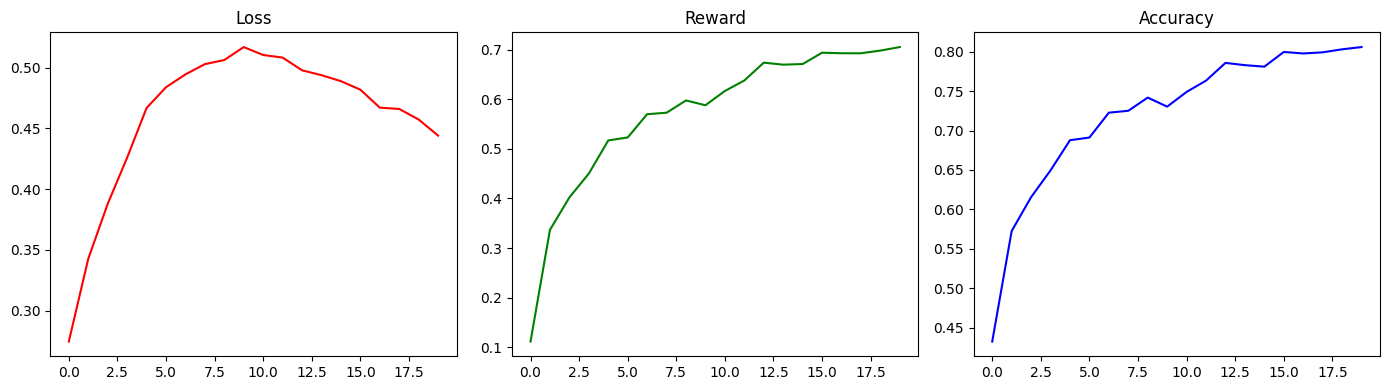

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(hist["loss"], 'r-'); axes[0].set_title("Loss")
axes[1].plot(hist["reward"], 'g-'); axes[1].set_title("Reward")
axes[2].plot(hist["acc"], 'b-'); axes[2].set_title("Accuracy")
plt.tight_layout(); plt.show()

---
# TRADITIONAL ML
---

## 6. Train ML Models

In [ ]:
print("\n" + "="*60)
print("TRAINING ML MODELS")
print("="*60)

def obj_xgb(trial):
    p = {'n_estimators': trial.suggest_int('n', 100, 400),
         'max_depth': trial.suggest_int('d', 3, 10),
         'learning_rate': trial.suggest_float('lr', 0.01, 0.2)}
    m = XGBClassifier(**p, random_state=42, verbosity=0)
    return cross_val_score(m, X_train_bal, y_train_bal, cv=3).mean()

print("Optimizing XGBoost (30 trials)...")
study = optuna.create_study(direction='maximize')
study.optimize(obj_xgb, n_trials=30, show_progress_bar=True)
xgb = XGBClassifier(**study.best_params, random_state=42, verbosity=0)
xgb.fit(X_train_bal, y_train_bal)

print("Training LightGBM...")
lgb = LGBMClassifier(n_estimators=300, max_depth=8, random_state=42, verbose=-1)
lgb.fit(X_train_bal, y_train_bal)

print("Training CatBoost...")
cat = CatBoostClassifier(iterations=300, depth=8, random_state=42, verbose=0)
cat.fit(X_train_bal, y_train_bal)

print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train_bal, y_train_bal)

print("Building Stacking Ensemble...")
stack = StackingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat), ('rf', rf)],
    final_estimator=LogisticRegression(max_iter=1000), cv=5
)
stack.fit(X_train_bal, y_train_bal)
print("✅ All done!")


TRAINING ML MODELS
Optimizing XGBoost (30 trials)...


Best trial: 6. Best value: 0.500717: 100%|██████████| 30/30 [03:59<00:00,  7.99s/it]


Training LightGBM...
Training CatBoost...
Training Random Forest...
Building Stacking Ensemble...
✅ All done!


## 7. Compare All Models

In [ ]:
print("\n" + "="*60)
print("MODEL COMPARISON: ML vs RL (14 Years Data)")
print("="*60)

models = {
    "DQN (RL)": (agent, X_test_sc),
    "XGBoost": (xgb, X_test),
    "LightGBM": (lgb, X_test),
    "CatBoost": (cat, X_test),
    "Random Forest": (rf, X_test),
    "Stacking": (stack, X_test)
}

results = []
for name, (m, Xe) in models.items():
    yp = m.predict(Xe)
    acc = accuracy_score(y_test, yp)
    prec = precision_score(y_test, yp, average='weighted')
    f1 = f1_score(y_test, yp, average='weighted')
    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "F1": f1})
    t = "RL" if "DQN" in name else "ML"
    print(f"[{t}] {name}: Acc={acc*100:.2f}%, Prec={prec*100:.2f}%")

df_res = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
df_res


MODEL COMPARISON: ML vs RL (14 Years Data)
[RL] DQN (RL): Acc=41.31%, Prec=41.65%
[ML] XGBoost: Acc=49.12%, Prec=47.65%
[ML] LightGBM: Acc=50.88%, Prec=49.54%
[ML] CatBoost: Acc=45.59%, Prec=43.80%
[ML] Random Forest: Acc=46.85%, Prec=44.93%
[ML] Stacking: Acc=42.32%, Prec=40.90%


,Model,Accuracy,Precision,F1
2,LightGBM,0.508816,0.495375,0.497184
1,XGBoost,0.491184,0.476540,0.478829
4,Random Forest,0.468514,0.449253,0.454756
3,CatBoost,0.455919,0.437958,0.443326
5,Stacking,0.423174,0.408990,0.414283
0,DQN (RL),0.413098,0.416501,0.414338


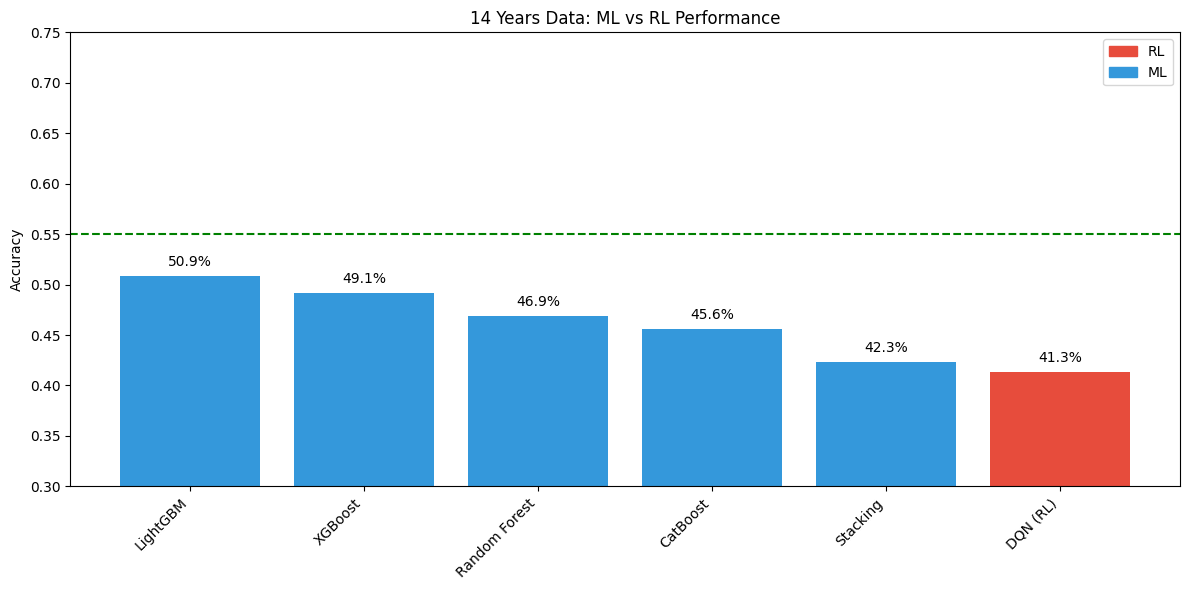

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#e74c3c' if 'DQN' in m else '#3498db' for m in df_res["Model"]]
bars = ax.bar(df_res["Model"], df_res["Accuracy"], color=colors)
ax.axhline(y=0.55, color='green', linestyle='--', label='55% Target')
ax.set_ylabel('Accuracy'); ax.set_title('14 Years Data: ML vs RL Performance')
ax.set_ylim(0.3, 0.75)
plt.xticks(rotation=45, ha='right')
for b, v in zip(bars, df_res["Accuracy"]):
    ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{v*100:.1f}%', ha='center')
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='#e74c3c', label='RL'), Patch(color='#3498db', label='ML')], loc='upper right')
plt.tight_layout(); plt.show()

In [ ]:
# Best model details
best_name = df_res.iloc[0]["Model"]
best_model = models[best_name][0]
best_acc = df_res.iloc[0]["Accuracy"]

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   Accuracy: {best_acc*100:.2f}%")
print(f"   Precision: {df_res.iloc[0]['Precision']*100:.2f}%")

yp = best_model.predict(models[best_name][1])
print("\n" + classification_report(y_test, yp, target_names=le.classes_))


🏆 BEST MODEL: LightGBM
   Accuracy: 50.88%
   Precision: 49.54%

              precision    recall  f1-score   support

           A       0.46      0.50      0.48       112
           D       0.39      0.26      0.31       104
           H       0.58      0.66      0.61       181

    accuracy                           0.51       397
   macro avg       0.48      0.47      0.47       397
weighted avg       0.50      0.51      0.50       397



## 8. Save Models

In [ ]:
torch.save({'state': agent.q_net.state_dict(), 'size': X_train_sc.shape[1]}, "dqn_model.pt")

artifacts = {
    "model": stack, "scaler": scaler, "le": le,
    "features": feature_cols, "metrics": {"accuracy": best_acc},
    "elo": elo_ratings, "teams": ALL_TEAMS
}
joblib.dump(artifacts, "football_prediction_model.pkl")
df_res.to_csv("model_performance.csv", index=False)

print(f"\n✅ Saved:")
print(f"   - dqn_model.pt (RL)")
print(f"   - football_prediction_model.pkl (ML)")
print(f"   - model_performance.csv")


✅ Saved:
   - dqn_model.pt (RL)
   - football_prediction_model.pkl (ML)
   - model_performance.csv


## 9. Interactive Prediction

In [ ]:
# Show some teams
print("Sample teams:", sorted(ALL_TEAMS)[:20])

def find_team(n):
    for t in ALL_TEAMS:
        if n.lower() in t.lower(): return t
    return None

home = input("\nHOME team: ").strip()
away = input("AWAY team: ").strip()
ht, at = find_team(home), find_team(away)

if ht and at and ht != at:
    today = datetime.now()
    hf = calc_form(df_matches, ht, today, 5)
    af = calc_form(df_matches, at, today, 5)
    h2h = calc_h2h(df_matches, ht, at, today, 5)
    he, ae = elo_ratings.get(ht, 1500), elo_ratings.get(at, 1500)
    
    feat = np.array([[he, ae, he-ae, 1/(1+10**((ae-he-100)/400)),
                      hf[0],hf[1],hf[2],hf[3],hf[4],hf[5],hf[6],hf[7],
                      af[0],af[1],af[2],af[3],af[4],af[5],af[6],af[7],
                      hf[0]-af[0],hf[3]-af[3],hf[7]-af[7],
                      h2h[0],h2h[1],h2h[2],h2h[3],
                      today.weekday(),today.month,1 if today.weekday()>=5 else 0]])
    feat_sc = scaler.transform(feat)
    out = {"H": "Home Win", "D": "Draw", "A": "Away Win"}
    
    print(f"\n{'='*50}")
    print(f"  {ht} vs {at}")
    print(f"{'='*50}")
    
    # DQN
    dqn_p = agent.get_probs(feat_sc[0])
    print(f"\n🤖 DQN (RL):")
    for i, p in enumerate(dqn_p): print(f"   {out[le.classes_[i]]}: {p*100:.1f}%")
    print(f"   → {out[le.classes_[np.argmax(dqn_p)]]}")
    
    # Stacking
    stk_p = stack.predict_proba(feat)[0]
    print(f"\n📊 Stacking (ML):")
    for i, p in enumerate(stk_p): print(f"   {out[le.classes_[i]]}: {p*100:.1f}%")
    print(f"   → {out[le.classes_[np.argmax(stk_p)]]}")
else:
    print("Team not found!")

Sample teams: ['AFC Bournemouth', 'Arsenal FC', 'Aston Villa FC', 'Athletic Club', 'Brentford FC', 'Brighton & Hove Albion FC', 'Burnley FC', 'CA Osasuna', 'CD Leganés', 'Chelsea FC', 'Club Atlético de Madrid', 'Crystal Palace FC', 'Cádiz CF', 'Deportivo Alavés', 'Elche CF', 'Everton FC', 'FC Barcelona', 'Fulham FC', 'Getafe CF', 'Girona FC']

  Liverpool FC vs Arsenal FC

🤖 DQN (RL):
   Away Win: 23.4%
   Draw: 46.9%
   Home Win: 29.7%
   → Draw

📊 Stacking (ML):
   Away Win: 57.8%
   Draw: 16.9%
   Home Win: 25.3%
   → Away Win
